<img src="Assets/header_final.png" style="width: 800px;">

# `Contents:`

- [Background](#background)
- [What is a network?](#whatisanetwork)    
- [A Game of Networks](#agameofnetworks)
- [Load Libraries](#loadlibraries)   
    
- [Load Edges & Nodes](#loadedgesandnodes)   
	- [Exploring the nodes](#exploringthenodes)
	- [Exploring the edges](#exploringtheedges)     
	- [Building the graph](#buildingthegraph)
	- [Drawing the graph](#drawingthegraph)  
    
- [Graph Metrics](#graphmetrics)   
	- [Degree](#degree)
	- [Betweeness Centrality](#betweenesscentrality)
	- [Degree and Betweeness Centrality - is there a relationship?](#degreeandbetweenesscentrality)          
	- [Building up the node dataframe](#buildingupthenodedataframe)
	- [Building up the edge dataframe](#buildinguptheedgedataframe)

- [Plotting Tools](#plottingtools)   
	- [Filtered Graph Plotter](#filteredgraphplotter)        

- [Ways we can use network science to answer questions about the characters](#questions)
	- [Which character pairings occur most often?](#often)
	- [Who is the most devoted character?](#devoted)
	- [What characters are yet to meet?](#unconnected)
	- [What house is the most important?](#house)
    


<a id="background"></a>
# `Background`
---

There are many cool things about Game of Thrones. If dragons, gore and incest aren't reason enough to pique your interest, the show's frequent ['WTF']("https://media2.giphy.com/media/fmJSIhRp9dhNm/giphy.gif") moments should be enough to create any fan.

However when I try and explain to 'non-throners' the appeal of the show, many baulk at the sheer number of characters that are part of it. Fair enough. There are almost **800** characters in the entire 'A Song of Ice and Fire' (ASOIAF) saga...and a lot of these relationships are explored through narrative heavily laden with exposition, which can be off putting. Buying into GoT can subsequntly feel a little cumbersome for noobs just starting out their journey in Westeros.  

Cue this project!

Having found an amazing data set online curated by [Andrew Beveridge]("https://github.com/mathbeveridge/asoiaf)   - I decided to use some network science techniques to explore all the characters in the ASOIAF saga and their relevant connections with one another. But first let's get under the skin of what a network is...

<a id="whatisanetwork"></a>
# `What is a Network?`
---

A network is a series of 'nodes', connected by 'edges'. If you spend a lot of time in London, you will be familiar with a network which well represents this relationship between node and edge. 

<img src="Assets/tube.png" style="width: 500px;">

The London Underground has stations (nodes) and lines (edges) that connect the stations. 

Collectively, all the nodes and edges represent a network, much like all the stations and lines of the Underground represent the tube network. 

Some stations have more lines connecting them to other stations than others (e.g. Kings Cross - five lines - vs. Angel - one line) and some stations are only accesible through certain lines - for example, you can only get to Old Street on the Underground using the Northern Line. As you can see, nodes and edges are simple concepts but can easily become nuanced, providing the network with its unique shape and function.

<a id="agameofnetworks"></a>
# `A Game of Networks`
---

Nodes and edges need not be limited to geography. The London Underground is a very 'tangible' example of a network however we can apply the same thinking to more abstract networks such as the relationships between individuals which was what I attempted with this project.

### `What can we explore?`

Using network science techniques we can explore how all the characters in the ASOIAF saga are connected. We can explore who has the most connections, who is connected to who and we can also work out who hasn't met yet. We can attempt to quantify what 'loyalty' or 'commitment' mean in a network. We can also use techniques to determine what aspects of a character infer 'importance' in a story.

<img src="Assets/brace.jpeg" style="width: 400px;">

<a id="loadlibraries"></a>
# `Load Libraries`
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx

plt.style.use('ggplot') 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter('ignore')


<a id="loadedgesandnodes"></a>
# `Load Edges & Nodes`
---

First thing first, we need to import our node and edge data. Fortunately it is already fairly clean with only a little editing to make it suitable for the analysis I want to do. 

In [2]:
#load the edge and node csv data
edge = pd.read_csv('asoiaf-all-edges.csv')
node = pd.read_csv('asoiaf-all-nodes.csv')

In [3]:
#get rid of any empty fields
edge = edge[edge.Target != 'Nan']
edge = edge[edge.Source != 'Nan']

In [4]:
#reset index
edge.reset_index(drop=True,inplace=True)

<a id="exploringthenodes"></a>
## `Exploring the nodes`

The node data in this data set is fairly simple; it consists of a series of unique characters from GoT - all 796 of them. We have two columns: an Id column and a Label column, which are pretty much replicas of each other.

In [5]:
node.head()

Id                             Label
0                    Addam-Marbrand                    Addam Marbrand
1       Aegon-Frey-(son-of-Stevron)       Aegon Frey (son of Stevron)
2                 Aegon-I-Targaryen                 Aegon I Targaryen
3  Aegon-Targaryen-(son-of-Rhaegar)  Aegon Targaryen (son of Rhaegar)
4                 Aegon-V-Targaryen                 Aegon V Targaryen

In [6]:
node.shape

(796, 2)

In [7]:
#let's add a unique identifier for each character - this will be useful later on
labels = [i for i in range(len(node.Id))]
node['Id_Code'] = node.index
node.head()

Id                             Label  Id_Code
0                    Addam-Marbrand                    Addam Marbrand        0
1       Aegon-Frey-(son-of-Stevron)       Aegon Frey (son of Stevron)        1
2                 Aegon-I-Targaryen                 Aegon I Targaryen        2
3  Aegon-Targaryen-(son-of-Rhaegar)  Aegon Targaryen (son of Rhaegar)        3
4                 Aegon-V-Targaryen                 Aegon V Targaryen        4

In [8]:
#a dictionary of characters and their unique ID's will useful for re-labelling our edges
got_dict = dict(zip(node.Id,labels))

<a id="exploringtheedges"></a>
## `Exploring the edges`

The edge data is also fairly simple; it consists of each connection between any given character and another character. The original author of this data set [Andrew Bevidge]("https://github.com/mathbeveridge/asoiaf") explains how he structured the edge data:

> *These networks were created by connecting two characters whenever their names (or nicknames) appeared within 15 words of one another in one of the books in "A Song of Ice and Fire."* 



In addition to the connections between characters, each connection has a 'weight' field:

> *The edge weight corresponds to the number of interactions.*

Some characters have more interactions throughout the saga. If we look at Jon Snow's interactions, we see some of the greater weightings make sense, Sam and Jon appear together frequently. They have one connection but have had multiple interactions with each other. Weight is explored in more detail later on.

<img src="Assets/jonsam.jpeg" style="width: 100;">

In [9]:
edge[(edge.Source == 'Jon-Snow')].sort_values(by='weight', ascending=False).head(1)

Source         Target        Type    id  weight
2025  Jon-Snow  Samwell-Tarly  Undirected  2031     228

Every edge is undirected so we can drop this column. We don't need Id so we can drop that too. Let's keep weight
it might be useful later on.

In [10]:
#drop Type and Id columns
edge.drop(['Type','id'],axis=1,inplace=True)

In [11]:
#looking good
edge.head()

Source            Target  weight
0  Addam-Marbrand     Brynden-Tully       3
1  Addam-Marbrand  Cersei-Lannister       3
2  Addam-Marbrand       Gyles-Rosby       3
3  Addam-Marbrand   Jaime-Lannister      14
4  Addam-Marbrand      Jalabhar-Xho       3

In order to set up the graph, it will be easier to do this if we give each character their own code. Using our GoT dictionary we made earlier, we can convert each edge into a numeric form. So instead of 'Jon-Snow/Samwell-Tarly' we can convert this relationship into a tuple (360,631), where 360 is Jon Snow's unique ID and 631 is Sam's unique ID. By doing this we are effectivley creating a huge array of tuples that will act as the inputs for our edge data when we construct the network.

In [12]:
edge['Source_Code'] = edge['Source'].apply(lambda x: got_dict[x])
edge['Target_Code'] = edge['Target'].apply(lambda x: got_dict[x])

In [13]:
edge[(edge.Source == 'Jon-Snow')].sort_values(by='weight', ascending=False).head()

Source             Target  weight  Source_Code  Target_Code
2025  Jon-Snow      Samwell-Tarly     228          360          631
2003  Jon-Snow       Mance-Rayder     112          360          439
2020  Jon-Snow         Robb-Stark      91          360          600
2033  Jon-Snow  Stannis-Baratheon      91          360          667
2050  Jon-Snow            Ygritte      80          360          788

Now we can create a list of edge tuples that include source id, target id and the relevant weight

In [14]:
edge_tuples= []
for i in range(0,len(edge.index)):
    edge_tuples.append((edge.Source_Code[i],edge.Target_Code[i]))

Let's a build a function that replicates this - we will need to use it again later

In [15]:
def tuple_extractor_edge(df):
    tuple_out = []
    for i in range(0,len(df.index)):
        tuple_out.append((df['Source_Code'][i],df['Target_Code'][i]))
    return tuple_out

and something similar but includes weight.

In [16]:
def tuple_extractor_edge_weight(df):
    tuple_out = []
    for i in range(0,len(df.index)):
        tuple_out.append((df['Source_Code'][i],df['Target_Code'][i],df['weight'][i]))
    return tuple_out

<a id="buildingthegraph"></a>
## `Building the graph`

Building the graph is quite simple - we will use the networkx library. We will create an instance of a graph class and then add to it the nodes and edge data. Once we have built and plotted the first graph we can look at some key metrics that are frequently used to describe the structure of network: A node's **degree** and a node's **betweeness centrality**.

In [17]:
#initiate the graph
G=nx.Graph()

In [18]:
#add the nodes
G.add_nodes_from(node.Id_Code)

In [19]:
#add the edges
for i in edge_tuples:
    G.add_edge(i[0],i[1])

<a id="drawingthegraph"></a>
## `Drawing the graph`

I'm going to use Plotly to visualise the network. I really like plotly - the syntax needs getting used to but it can create some really nice looking visualisations. It also has super useful tools that will help us explore the network interactively.

In [20]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='kitsamho', api_key='ocYv7z1stxKLNd8ZoaUT')
# plotly.tools.set_config_file(world_readable=True,sharing='public')

In [21]:
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
init_notebook_mode(connected=True)

## Coding the different Houses

It will be useful to identify the different houses in our graph - we can create a custom colour map to use as part of a plotly kwarg later on. Regular expressions will probably be the easiest way to extract the relevant data that will allow us to build a custom map.

In [22]:
#function that takes two argments, a house (string) and an input variable. 
#The function returns true if the house is present in the input variable
import regex as re
def house(x,house):
    if re.search(f'^(?!.*details\.cfm).*{house}.*$',x):
        return True
    else:
        return False

In [23]:
#we need a reference list so we can iterate through every character and append the colour to the colour map
reference = list(node.Id)

In [24]:
#make the colour map that we can use to colour code the nodes in our graph
color_map = []
for i in reference:
    if house(i,'Lannister'):
        color_map.append('blue')
    elif house(i,'Targaryen'):   
        color_map.append('red')
    elif house(i,'Baratheon'):   
        color_map.append('green')
    elif house(i,'Tully'):   
        color_map.append('orange')
    elif house(i,'Martell'):   
        color_map.append('purple')
    elif house(i,'Stark'):   
        color_map.append('lightblue')
    elif house(i,'Jon-Snow'):   
        color_map.append('lightblue')
    elif house(i,'Selmy'):   
        color_map.append('lime')
    elif house(i,'Tarly'):   
        color_map.append('yellow')
    elif house(i,'Tyrell'):   
        color_map.append('hotpink')
    elif house(i,'Arryn'):   
        color_map.append('aliceblue')
    elif house(i,'Greyjoy'):   
        color_map.append('pink')
    elif house(i,'Bolton'):   
        color_map.append('maroon')
    else: 
        color_map.append('darkgrey')      

In [25]:
# function that takes a graph as an input and plots a layout using the Kamada Kawai Layout as default
def plot(G,title='',size_metric=5,layout=nx.kamada_kawai_layout):
    #choose the layout we want
    pos=layout(G) 
    
    Xn=[pos[k][0] for k in range(len(pos))]
    Yn=[pos[k][1] for k in range(len(pos))]
    
    
    #contstruct nodes
    trace_nodes=dict(type='scatter',
                     x=Xn, 
                     y=Yn,
                     mode='markers',
                     marker=dict(size=size_metric, color=color_map),
                     text=node.Id,
                     hoverinfo='text')

    Xe=[]
    Ye=[]
    for e in G.edges():
        Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
        Ye.extend([pos[e[0]][1], pos[e[1]][1], None])

    trace_edges=dict(type='scatter',mode='lines',x=Xe,y=Ye,line=dict(width=0.09, color='#A3A3A3'),hoverinfo='none')

    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
              zeroline=False,
              showgrid=False,
              showticklabels=False,
              title='' 
              )
    layout=dict(title= f'Relationships in the Game of Thrones{title}',  
                font= dict(family='Arial'),
                width=1100,
                height=1100,
                autosize=False,
                showlegend=False,
                xaxis=axis,
                yaxis=axis,
                margin=dict(
                l=40,
                r=40,
                b=85,
                t=100,
                pad=0,

        ),
        hovermode='closest',
        plot_bgcolor='black', #set background color            
        )


    fig = dict(data=[trace_edges, trace_nodes], layout=layout)
    return iplot(fig)

In [26]:
plot(G)

<a id="graphmetrics"></a>
# `Graph Metrics`
----

Now we have our first graph and managed to visualise it - let's explore some key graph concepts.

<a id="degree"></a>
## `Degree`



The degree of a node indicates how many **unique edges** a node has. In the context of the GoT data we are using, the degrees represent the number of unique connections characters have with one another. A character with a high degree is someone that gets mentioned in context with a lot of other characters i.e. someone who is likely to be quite important to the narrative. A character with a low degree is someone that doesn't have many interactions with other characters in the narrative.

## A simple explanation of degree

In [27]:
Deg = nx.Graph()

Deg.add_node('James')
Deg.add_node('Kirk')
Deg.add_node('Lars')
Deg.add_node('Cliff')

Deg.add_node('Kurt')
Deg.add_node('Kris')
Deg.add_node('Dave')


Deg.add_edge('James','Kirk')
Deg.add_edge('James','Lars')
Deg.add_edge('James','Cliff')



Deg.add_edge('Kurt','Kris')
Deg.add_edge('Kurt','Dave')

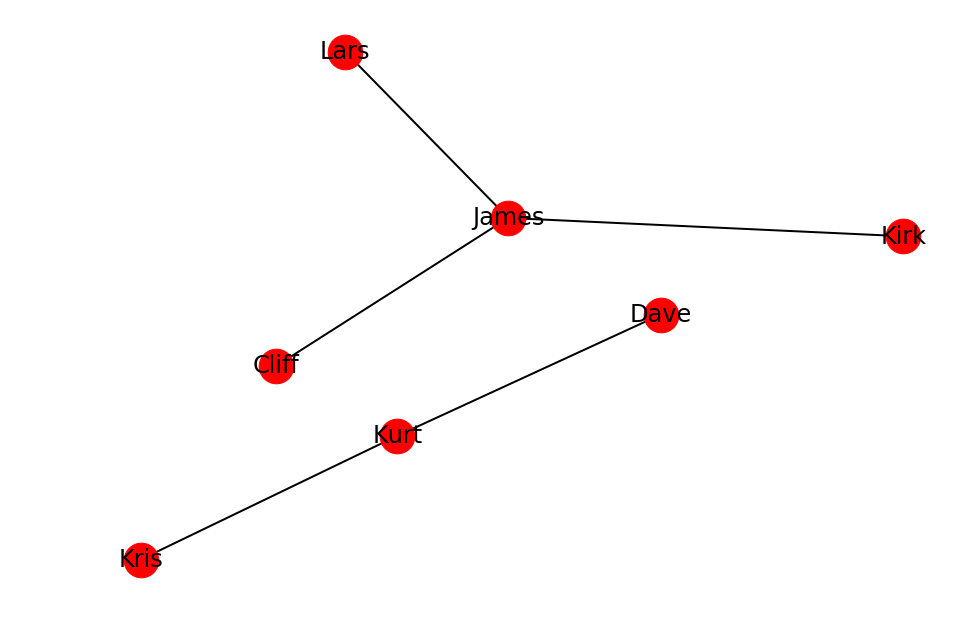

In [28]:
nx.draw_kamada_kawai(Deg,with_labels=True)

In this example above - there are seven people in this network and five connections (edges). We can see that the network consists of two smaller, 'sub' networks with James being the most connected in one network and Kurt being most connected in the other. When we look at the degree of James and Kurt we have 3 and 2 respectively, that is that James has three connections and Kurt has two. In this scenario, James and Kurt are the two most well connected individuals in the network.

In [29]:
pd.DataFrame({'Person':list(dict(Deg.degree).keys()),'Degree':list(dict(Deg.degree).values())}).sort_values(by='Degree', ascending = False)

Person  Degree
0  James       3
4   Kurt       2
1   Kirk       1
2   Lars       1
3  Cliff       1
5   Kris       1
6   Dave       1

Now let's explore this concept with the Game of Thrones data. As we can see, some of the characters with high degrees are indeed some of the more well known characters from the series. These are characters that have narrative connections with many other characters in the saga.

In [30]:
#let's look at which characters have the greatest degrees (i.e number of connections)
pd.DataFrame({'Character': list(got_dict.keys()),'Degrees':list(dict(G.degree).values())}).sort_values(by='Degrees',ascending=False).head(5)

Character  Degrees
726   Tyrion-Lannister      122
360           Jon-Snow      113
336    Jaime-Lannister      101
115   Cersei-Lannister       97
667  Stannis-Baratheon       89

Contrastingly if we look at characters with the smallest degree - we find some very obscure characters.

In [31]:
pd.DataFrame({'Character': list(got_dict.keys()),'Degrees':list(dict(G.degree).values())}).sort_values(by='Degrees',ascending=False).tail(5)

Character  Degrees
212             Ezzara        1
424  Lynesse-Hightower        1
214             Farlen        1
220            Frenken        1
501                Nan        0

Let's plot the GoT graph again, but make the size of each node relative to the degree each character has. 

*(The number of edges coming from each node is the degree but representing this visually using size makes it easier to pick out characters with higher degree.)*

In [32]:
#list denoting the size of node by degree
size_map_degrees = [i/3 for i in dict(G.degree).values()]

In [33]:
plot(G,'- node size representing character degrees.',size_map_degrees)

<a id="betweenesscentrality"></a>
## `Betweeness Centrality`

Another important feature of a network which helps us to understand how important some nodes are in the network is a node's **'betweeness centrality'**. In simple terms this is the extent to which individual characters are able to 'bridge' other parts of the network. Let's explore this with our example from before. 



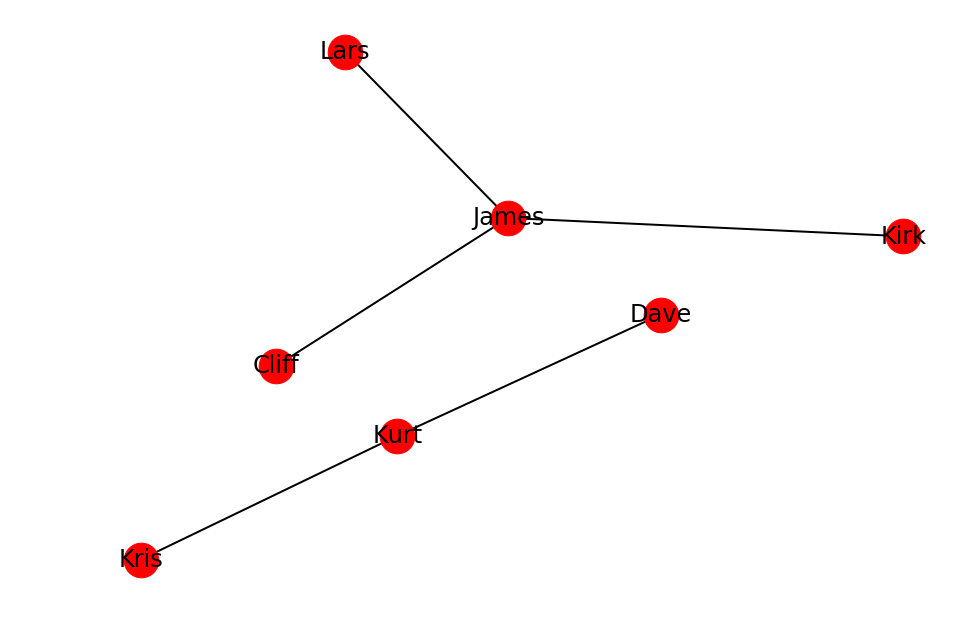

In [34]:
nx.draw_kamada_kawai(Deg,with_labels=True)

Earlier on we found that James and Kurt had the most degrees i.e. these two people had the most connections with other nodes in the network. What happens if we introduce an seventh node linking James and Kurt?

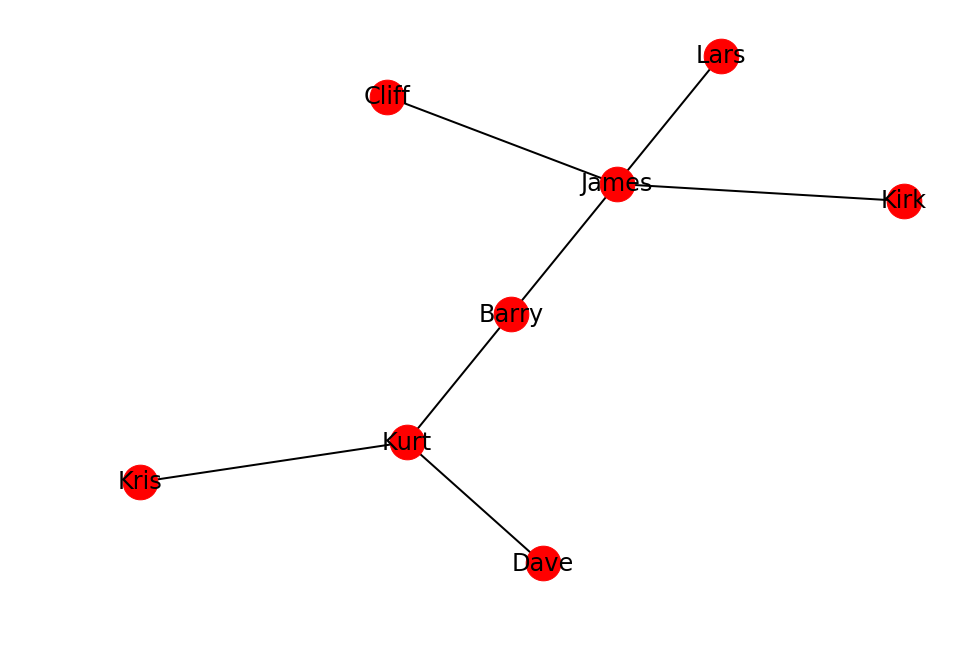

In [35]:
Deg.add_node('Barry')
Deg.add_edge('Barry','James')
Deg.add_edge('Barry','Kurt')
nx.draw_kamada_kawai(Deg,with_labels=True)

As expected, James has four degrees, Kurt has three and Barry has two. 

In [36]:
pd.DataFrame({'Person':list(dict(Deg.degree).keys()),'Degree':list(dict(Deg.degree).values())}).sort_values(by='Degree', ascending = False)

Person  Degree
0  James       4
4   Kurt       3
7  Barry       2
1   Kirk       1
2   Lars       1
3  Cliff       1
5   Kris       1
6   Dave       1

However Barry is important in that he bridges the two previous groups. This ability can be described by a node's **betweeness centrality**, and as we can see - whilst Barry has fewer degrees than Kurt (is directly connected to *fewer* individuals) , his centrality in the network is higher. 

In [37]:
pd.DataFrame({'Person':list(dict(Deg.degree).keys()),
              'Degree':list(dict(Deg.degree).values()),
              'Centrality':list(dict(nx.betweenness_centrality(Deg)).values()),
             }).sort_values(by='Centrality', ascending = False)

Person  Degree  Centrality
0  James       4    0.714286
7  Barry       2    0.571429
4   Kurt       3    0.523810
1   Kirk       1    0.000000
2   Lars       1    0.000000
3  Cliff       1    0.000000
5   Kris       1    0.000000
6   Dave       1    0.000000

So to recap - whilst the number of connections a node has can help to describe how important a node is within the network, betweeness centrality is also important as it describes a node's ability in *connecting* the network. 

<a id="degreeandbetweenesscentrality"></a>
## `Degree and Betweeness Centrality - is there a relationship?`

In [38]:
deg_cen = pd.DataFrame({'Character':list(got_dict.keys()),
              'Degree':list(dict(G.degree).values()),
              'Centrality':list(dict(nx.betweenness_centrality(G)).values()),
             }).sort_values(by='Degree', ascending = False)

There is a reasonably strong positive relationship (0.88) between degree and centrality in a GoT i.e. the more individual connections a character has, the more likely they are to be successful in connecting the entire network.

In [39]:
deg_cen.corr()

Degree  Centrality
Degree      1.000000    0.886734
Centrality  0.886734    1.000000

If we focus in on characters with degrees of 35 or higher (our well connected characters) we see that there are some, that compared to the trend, have relatively higher between centrality than others - Jon Snow, Theon Greyjoy and Danearys Targaryen stand out in particular. These are characters that have higher than a 'predicted' level of centrality given the number of connections they have. This means they are good at bridging different groups across the network. Jon and Danearys aren't surprising, but Theon is a little suprising.

In [40]:
deg_cen_mask = deg_cen[deg_cen.Degree >= 35]

In [41]:
deg_cen_mask.shape

(22, 3)

In [42]:
deg_cen_mask.reset_index(drop=True,inplace=True)

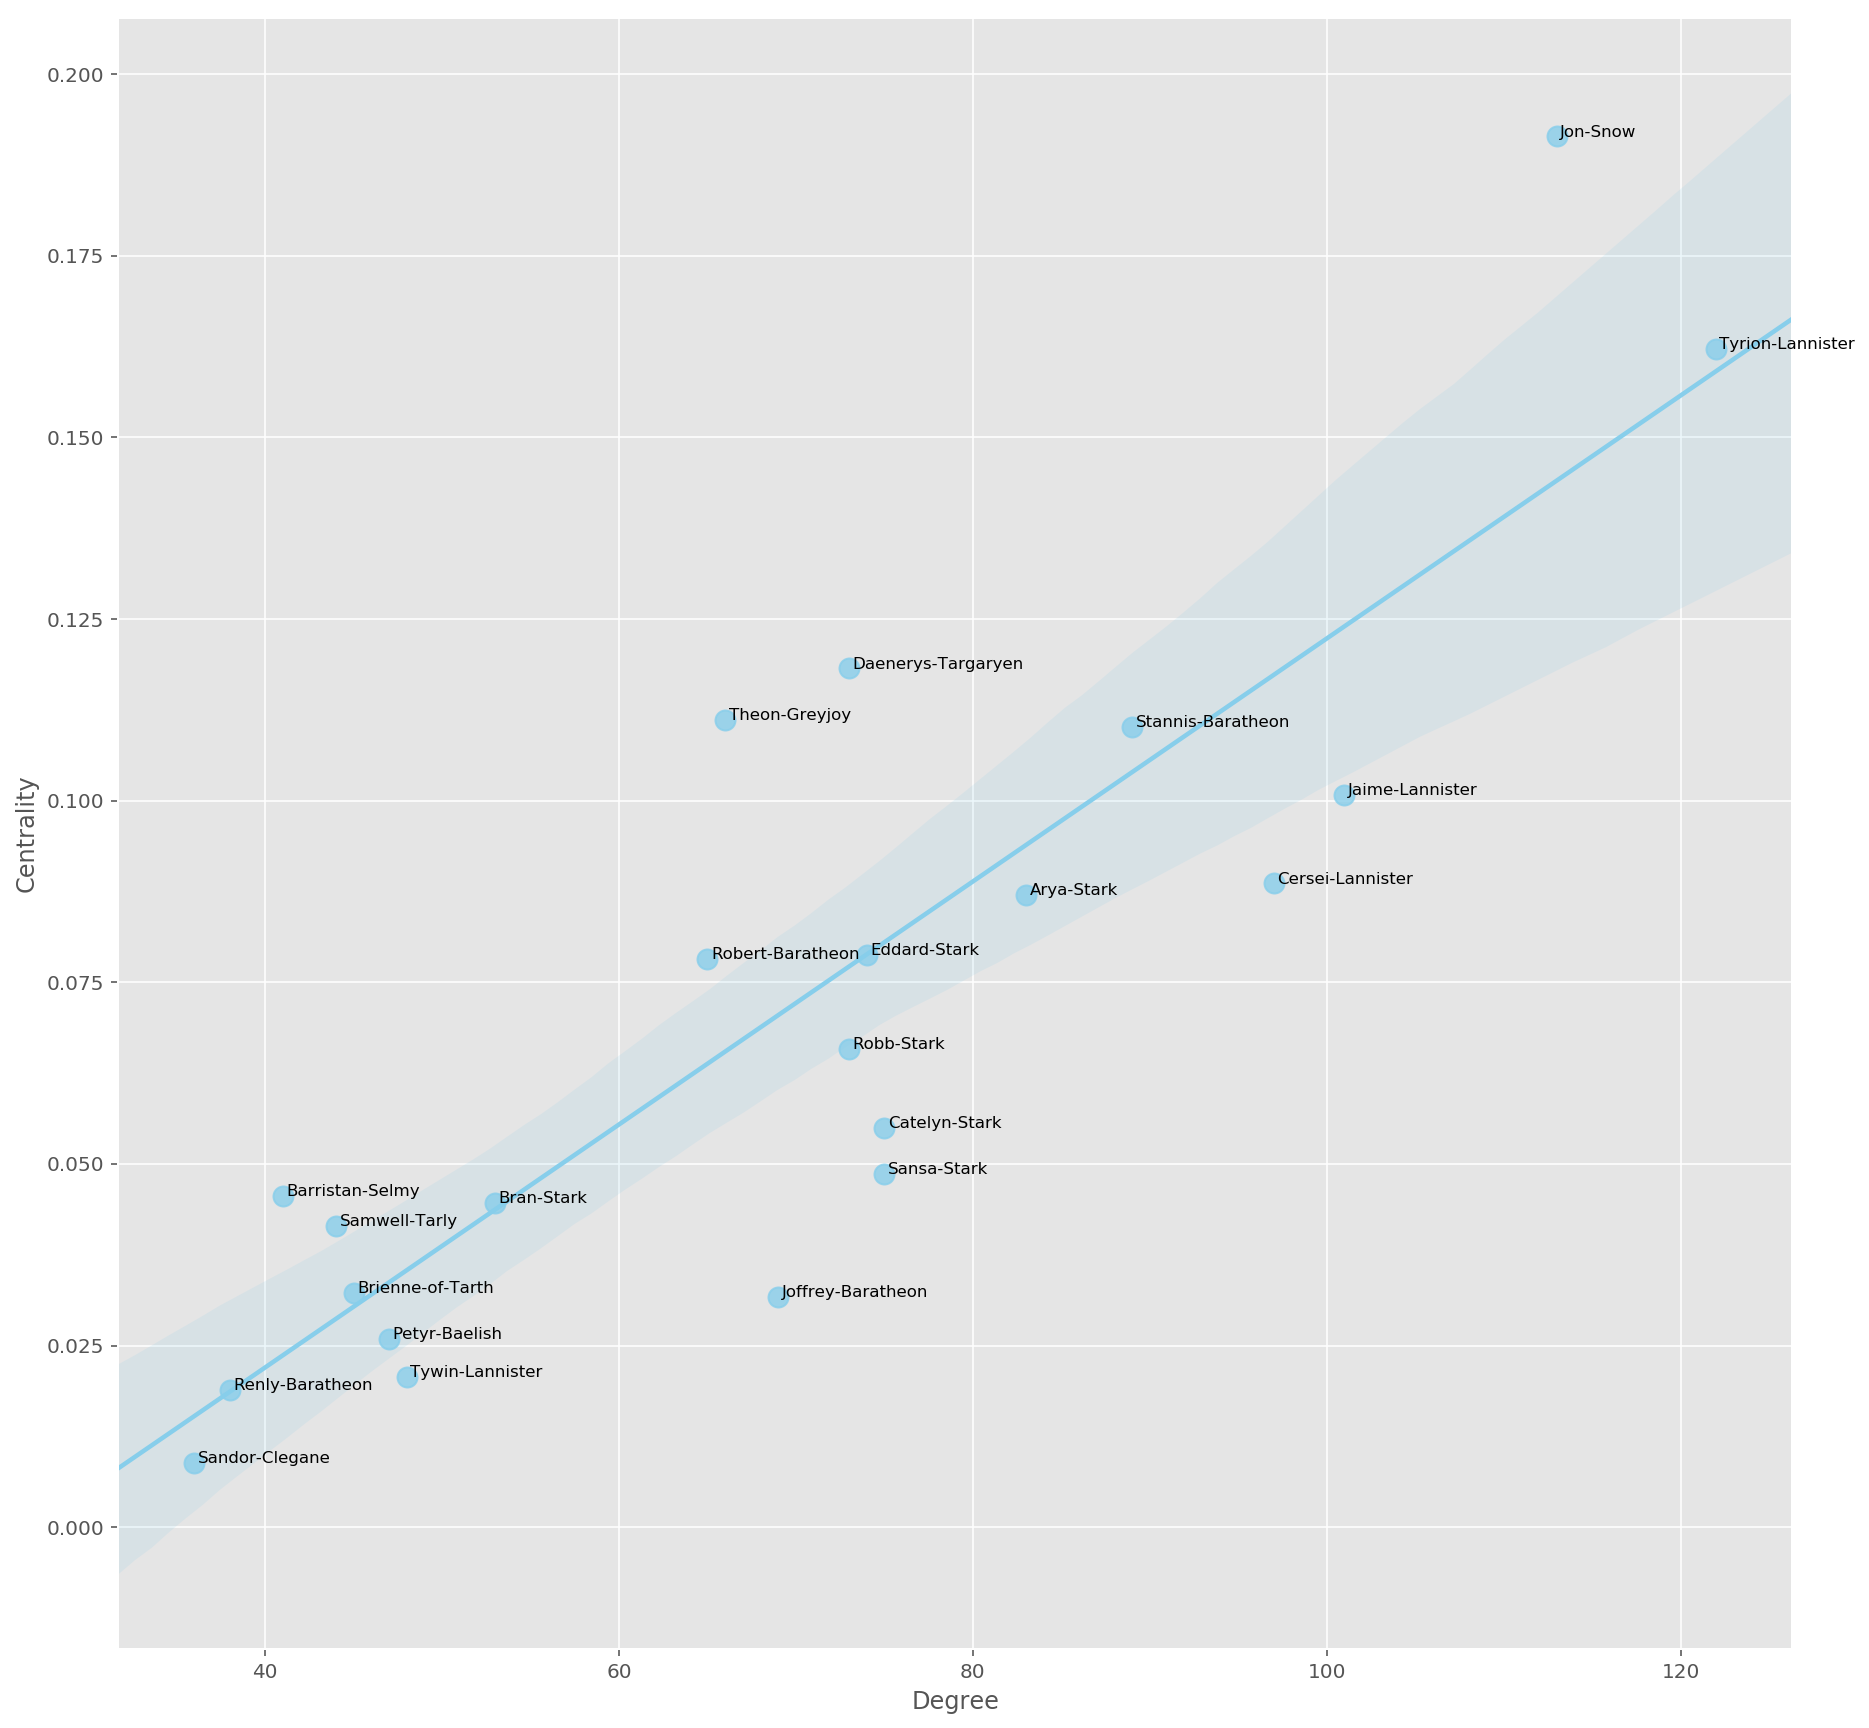

In [43]:
fig = plt.figure(figsize=(15, 15)) 
ax = fig.gca()
p1=sns.regplot(data=deg_cen_mask, x="Degree", y="Centrality", fit_reg=True, marker="o", color="skyblue", scatter_kws={'s':100})

for line in range(0,deg_cen_mask.shape[0]):
    p1.text(deg_cen_mask.Degree[line]+0.2, deg_cen_mask.Centrality[line], deg_cen_mask.Character[line], horizontalalignment='left', size='small', color='black', weight='light')


Let's visualise the GoT network with node size representing a nodes betweeness centrality. As confirmed by the analysis above, Theon Greyjoy stands out among the other characters when we make node size relevant to character centrality.

In [44]:
#list denoting the size of node by centrality in the network
size_map_centrality = [i*250 for i in nx.betweenness_centrality(G).values()]

In [45]:
plot(G,'- node size representing centrality.',size_map_centrality)

<a id="buildingupthenodedataframe"></a>
# `Building up the node dataframe`


Let's collate all these key metrics and build them into a dataframe so we can do further analysis.

In [46]:
got_nodes = pd.DataFrame({'Id':node.Id_Code,'Character':list(got_dict.keys()),
              'Degree':list(dict(G.degree).values()),
              'Centrality':list(dict(nx.betweenness_centrality(G)).values()),
             })

In [47]:
got_nodes.head()

Id                         Character  Degree  Centrality
0   0                    Addam-Marbrand      12    0.000470
1   1       Aegon-Frey-(son-of-Stevron)       4    0.000000
2   2                 Aegon-I-Targaryen       8    0.006580
3   3  Aegon-Targaryen-(son-of-Rhaegar)      15    0.006005
4   4                 Aegon-V-Targaryen       1    0.000000

Adding houses..

In [48]:
key_houses = ['Lannister','Targaryen','Baratheon','Tully',
                'Martell','Stark','Jon-Snow','Tarly','Greyjoy','Arryn',
                'Bolton','Frey','Cassel','Clegane','Selmy','Tyrell'
             ]
def house_label(i):
    for x in key_houses:
        if house(i,x):
            return x
    else: 
        return

In [49]:
#let's add the houses to help with plotting
got_nodes['House'] = got_nodes.Character.apply(lambda x: house_label(x))

In [50]:
got_nodes.head()

Id                         Character  Degree  Centrality      House
0   0                    Addam-Marbrand      12    0.000470       None
1   1       Aegon-Frey-(son-of-Stevron)       4    0.000000       Frey
2   2                 Aegon-I-Targaryen       8    0.006580  Targaryen
3   3  Aegon-Targaryen-(son-of-Rhaegar)      15    0.006005  Targaryen
4   4                 Aegon-V-Targaryen       1    0.000000  Targaryen

<a id="buildinguptheedgedataframe"></a>
# `Building up the edge dataframe`

Let's add the degrees of each character in the edge dataframe

In [51]:
got_edges = edge.copy()

In [52]:
#create a dictionary containing characters and their degrees
got_dict_degree = dict(zip(list(got_nodes.Character),list(got_nodes.Degree)))

In [53]:
got_edges['Source_Degree'] = got_edges.Source.apply(lambda x: got_dict_degree[x])
got_edges['Target_Degree'] = got_edges.Target.apply(lambda x: got_dict_degree[x])

In [54]:
got_edges.head()

Source            Target  weight  Source_Code  Target_Code  \
0  Addam-Marbrand     Brynden-Tully       3            0          101   
1  Addam-Marbrand  Cersei-Lannister       3            0          115   
2  Addam-Marbrand       Gyles-Rosby       3            0          272   
3  Addam-Marbrand   Jaime-Lannister      14            0          336   
4  Addam-Marbrand      Jalabhar-Xho       3            0          337   

   Source_Degree  Target_Degree  
0             12             19  
1             12             97  
2             12             18  
3             12            101  
4             12              5

<a id="plottingtools"></a>
# Plotting Tools
---

### `Helper Functions`

These functions will help us filter our edge and nodes dataframes - which will make things easier for subsetting our data if needed.

In [55]:
#returns a filtered edge dataframe based on degree
def edge_filter(edge,degree):
    return edge[(edge.Source_Degree >= degree) & (edge.Target_Degree >= degree)].reset_index(drop=True)

#returns a node dataframe based on the nodes in an existing edge dataframe
def node_filter(edge,node):
    subset = list(set(list(edge['Source_Code'])+list(edge['Target_Code'])))
    node = node.iloc[subset,:].reset_index(drop=True)
    node['Id'] = node.index
    return node

<a id="filteredgraphplotter"></a>
## Filtered Graph Plotter

Let's create a comprehensive function that takes the original node and edge data and a degree of choice, returning a plot. This will allow us to create graph plots but based on fewer characters.

In [56]:
def plotter(edge,node,degree,layout=nx.kamada_kawai_layout):
        
    new_edge = edge_filter(edge,degree)
    new_node = node_filter(new_edge,node)
    
    labels = [i for i in range(len(new_node.Character))]
    temp_dict = dict(zip(new_node.Character,labels))
    new_edge['Source_Code'] = new_edge['Source'].apply(lambda x: temp_dict[x])
    new_edge['Target_Code'] = new_edge['Target'].apply(lambda x: temp_dict[x])
    
    G=nx.Graph()
    G.add_nodes_from(new_node.Id)
    for i in tuple_extractor_edge(new_edge):
        G.add_edge(i[0],i[1])
        
    
    if degree <10:
        a = 3
    elif degree <15:
        a = 2
    elif degree <20:
        a = 1
    elif degree <30:
        a = 0.5
    elif degree <50:
        a = 0.3
    elif degree <80:
        a = 0.2
    else:
        a = 0.1
        
    size_map_degrees = [i/a for i in dict(G.degree).values()]
    
    def house(x,house):
        if re.search(f'^(?!.*details\.cfm).*{house}.*$',x):
            return True
        else:
            return False

    reference = list(new_node.Character)
    color_map = []
    for i in reference:
        if house(i,'Lannister'):
            color_map.append('blue')
        elif house(i,'Targaryen'):   
            color_map.append('red')
        elif house(i,'Baratheon'):   
            color_map.append('green')
        elif house(i,'Tully'):   
            color_map.append('orange')
        elif house(i,'Martell'):   
            color_map.append('purple')
        elif house(i,'Stark'):   
            color_map.append('lightblue')
        elif house(i,'Jon-Snow'):   
            color_map.append('lightblue')
        elif house(i,'Selmy'):   
            color_map.append('lime')
        elif house(i,'Tarly'):   
            color_map.append('yellow')
        elif house(i,'Tyrell'):   
            color_map.append('hotpink')
        elif house(i,'Arryn'):   
            color_map.append('aliceblue')
        elif house(i,'Greyjoy'):   
            color_map.append('pink')
        elif house(i,'Bolton'):   
            color_map.append('maroon')
        else: 
            color_map.append('darkgrey') 
    
    pos=layout(G) 
    
    Xn=[pos[k][0] for k in range(len(pos))]
    Yn=[pos[k][1] for k in range(len(pos))]
    
    
    #contstruct nodes
    trace_nodes=dict(type='scatter',
                     x=Xn, 
                     y=Yn,
                     mode='markers',
                     marker=dict(size=size_map_degrees, color=color_map),
                     text=new_node.Character,
                     hoverinfo='text')

    Xe=[]
    Ye=[]
    for e in G.edges():
        Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
        Ye.extend([pos[e[0]][1], pos[e[1]][1], None])

    trace_edges=dict(type='scatter',mode='lines',x=Xe,y=Ye,line=dict(width=0.09, color='#A3A3A3'),hoverinfo='none')

    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
              zeroline=False,
              showgrid=False,
              showticklabels=False,
              title='' 
              )
    layout=dict(title= 'Relationships in the Game of Thrones',  
                font= dict(family='Arial'),
                width=1000,
                height=1000,
                autosize=False,
                showlegend=False,
                xaxis=axis,
                yaxis=axis,
                margin=dict(
                l=40,
                r=40,
                b=85,
                t=100,
                pad=0,

        ),
        hovermode='closest',
        plot_bgcolor='black', #set background color            
        )


    fig = dict(data=[trace_edges, trace_nodes], layout=layout)
    return iplot(fig)
    
  

Now we can plot the network based on charactered that have a certain degree. Makes things easier to read.

In [57]:
plotter(got_edges,got_nodes,40)

<a id="questions"></a>
# Using network science to answer questions about the story

<a id="mostfoten"></a>
## `Which character pairings occur most often?`

Ok, so we know that nodes represent characters and edges represent the connection between characters. The **weight** of an edge indicates another feature of the node/edge relationship.

In our earlier London Underground example the weight of an edge could represent how many people take a specific journey between two stations in a given day. You would expect that perhaps therefore that the weight of the edge connecting London Bridge and Waterloo would be much higher compared to say the weight of the edge represented by the connection between stations further from central London e.g. Morden and South Wimbledon. After all there are usually more people travelling between stations in zone 1 than the stations in zone 6.

>**Weights give us more information about how nodes are connected with one another in a network**

We can apply this same principle with our character data from GoT. The weights in our character data represent *how many seperate times* two characters have had with one another. An edge with a low weight represents a connection between two characters that have had fewer connections with one another. Contrastingly, an edge with a high weight represents two characters that have encountered each other many times. 



Let's look at the edges with the biggest weights i.e. character pairings that occur frequently. 

The connection between Ned and Rob has the biggest weight. This is a relationship that is represented by many interactions. 

In [58]:
got_edges.sort_values(by='weight',ascending=False).head(5)

Source            Target  weight  Source_Code  Target_Code  \
1331       Eddard-Stark  Robert-Baratheon     334          189          602   
2025           Jon-Snow     Samwell-Tarly     228          360          631   
1960  Joffrey-Baratheon       Sansa-Stark     222          354          633   
1967  Joffrey-Baratheon  Tyrion-Lannister     219          354          726   
638          Bran-Stark             Hodor     209           89          306   

      Source_Degree  Target_Degree  
1331             74             65  
2025            113             44  
1960             69             75  
1967             69            122  
638              53             10

<img src="Assets/robed.jpg" style="width: 400px;">

We can make a function that presents this data in a more interesting way - a heatmap representing the adjacency matrix of the graph would work well.

In [59]:
#a function that takes the top level edge and node dataframes, constructs a graph that includes weights
#and returns a heatmap with the edge weights colour formatted. There is an option to filter on nodes that have 
#a threshold degree level
def weight_matrix(edge,node,degree):
    
    new_edge = edge_filter(edge,degree)
    new_node = node_filter(new_edge,node)
    
    labels = [i for i in range(len(new_node.Character))]
    temp_dict = dict(zip(new_node.Character,labels))
    new_edge['Source_Code'] = new_edge['Source'].apply(lambda x: temp_dict[x])
    new_edge['Target_Code'] = new_edge['Target'].apply(lambda x: temp_dict[x])
    
    G=nx.Graph()
    G.add_nodes_from(new_node.Id)
    for i in tuple_extractor_edge_weight(new_edge):
        G.add_edge(i[0],i[1],weight=i[2])
    a = pd.DataFrame(nx.adjacency_matrix(G,weight='weight').todense())
    a.columns = list(temp_dict.keys())
    a.index = list(temp_dict.keys())
    

    return a

In [60]:
weight_matrix(got_edges,got_nodes,75)

Jon-Snow  Catelyn-Stark  Arya-Stark  Jaime-Lannister  \
Jon-Snow                  0             14          71                3   
Catelyn-Stark            14              0           8               59   
Arya-Stark               71              8           0               13   
Jaime-Lannister           3             59          13                0   
Cersei-Lannister          7             30          25              130   
Tyrion-Lannister         56             69          11              113   
Sansa-Stark              11             32         155               23   
Stannis-Baratheon        91             24           0               12   

                   Cersei-Lannister  Tyrion-Lannister  Sansa-Stark  \
Jon-Snow                          7                56           11   
Catelyn-Stark                    30                69           32   
Arya-Stark                       25                11          155   
Jaime-Lannister                 130               113           23   
Cersei-Lannister                  0               209           95   
Tyrion-Lannister                209                 0          118   
Sansa-Stark                      95               118            0   
Stannis-Baratheon                42                52           11   

                   Stannis-Baratheon  
Jon-Snow                          91  
Catelyn-Stark                     24  
Arya-Stark                         0  
Jaime-Lannister                   12  
Cersei-Lannister                  42  
Tyrion-Lannister                  52  
Sansa-Stark                       11  
Stannis-Baratheon                  0

In [61]:
def weight_map(x,h=8,v=8):
    mask = np.zeros_like(x)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize = (h,v))
    return sns.heatmap(x,mask=mask,square=False,cmap='Blues')

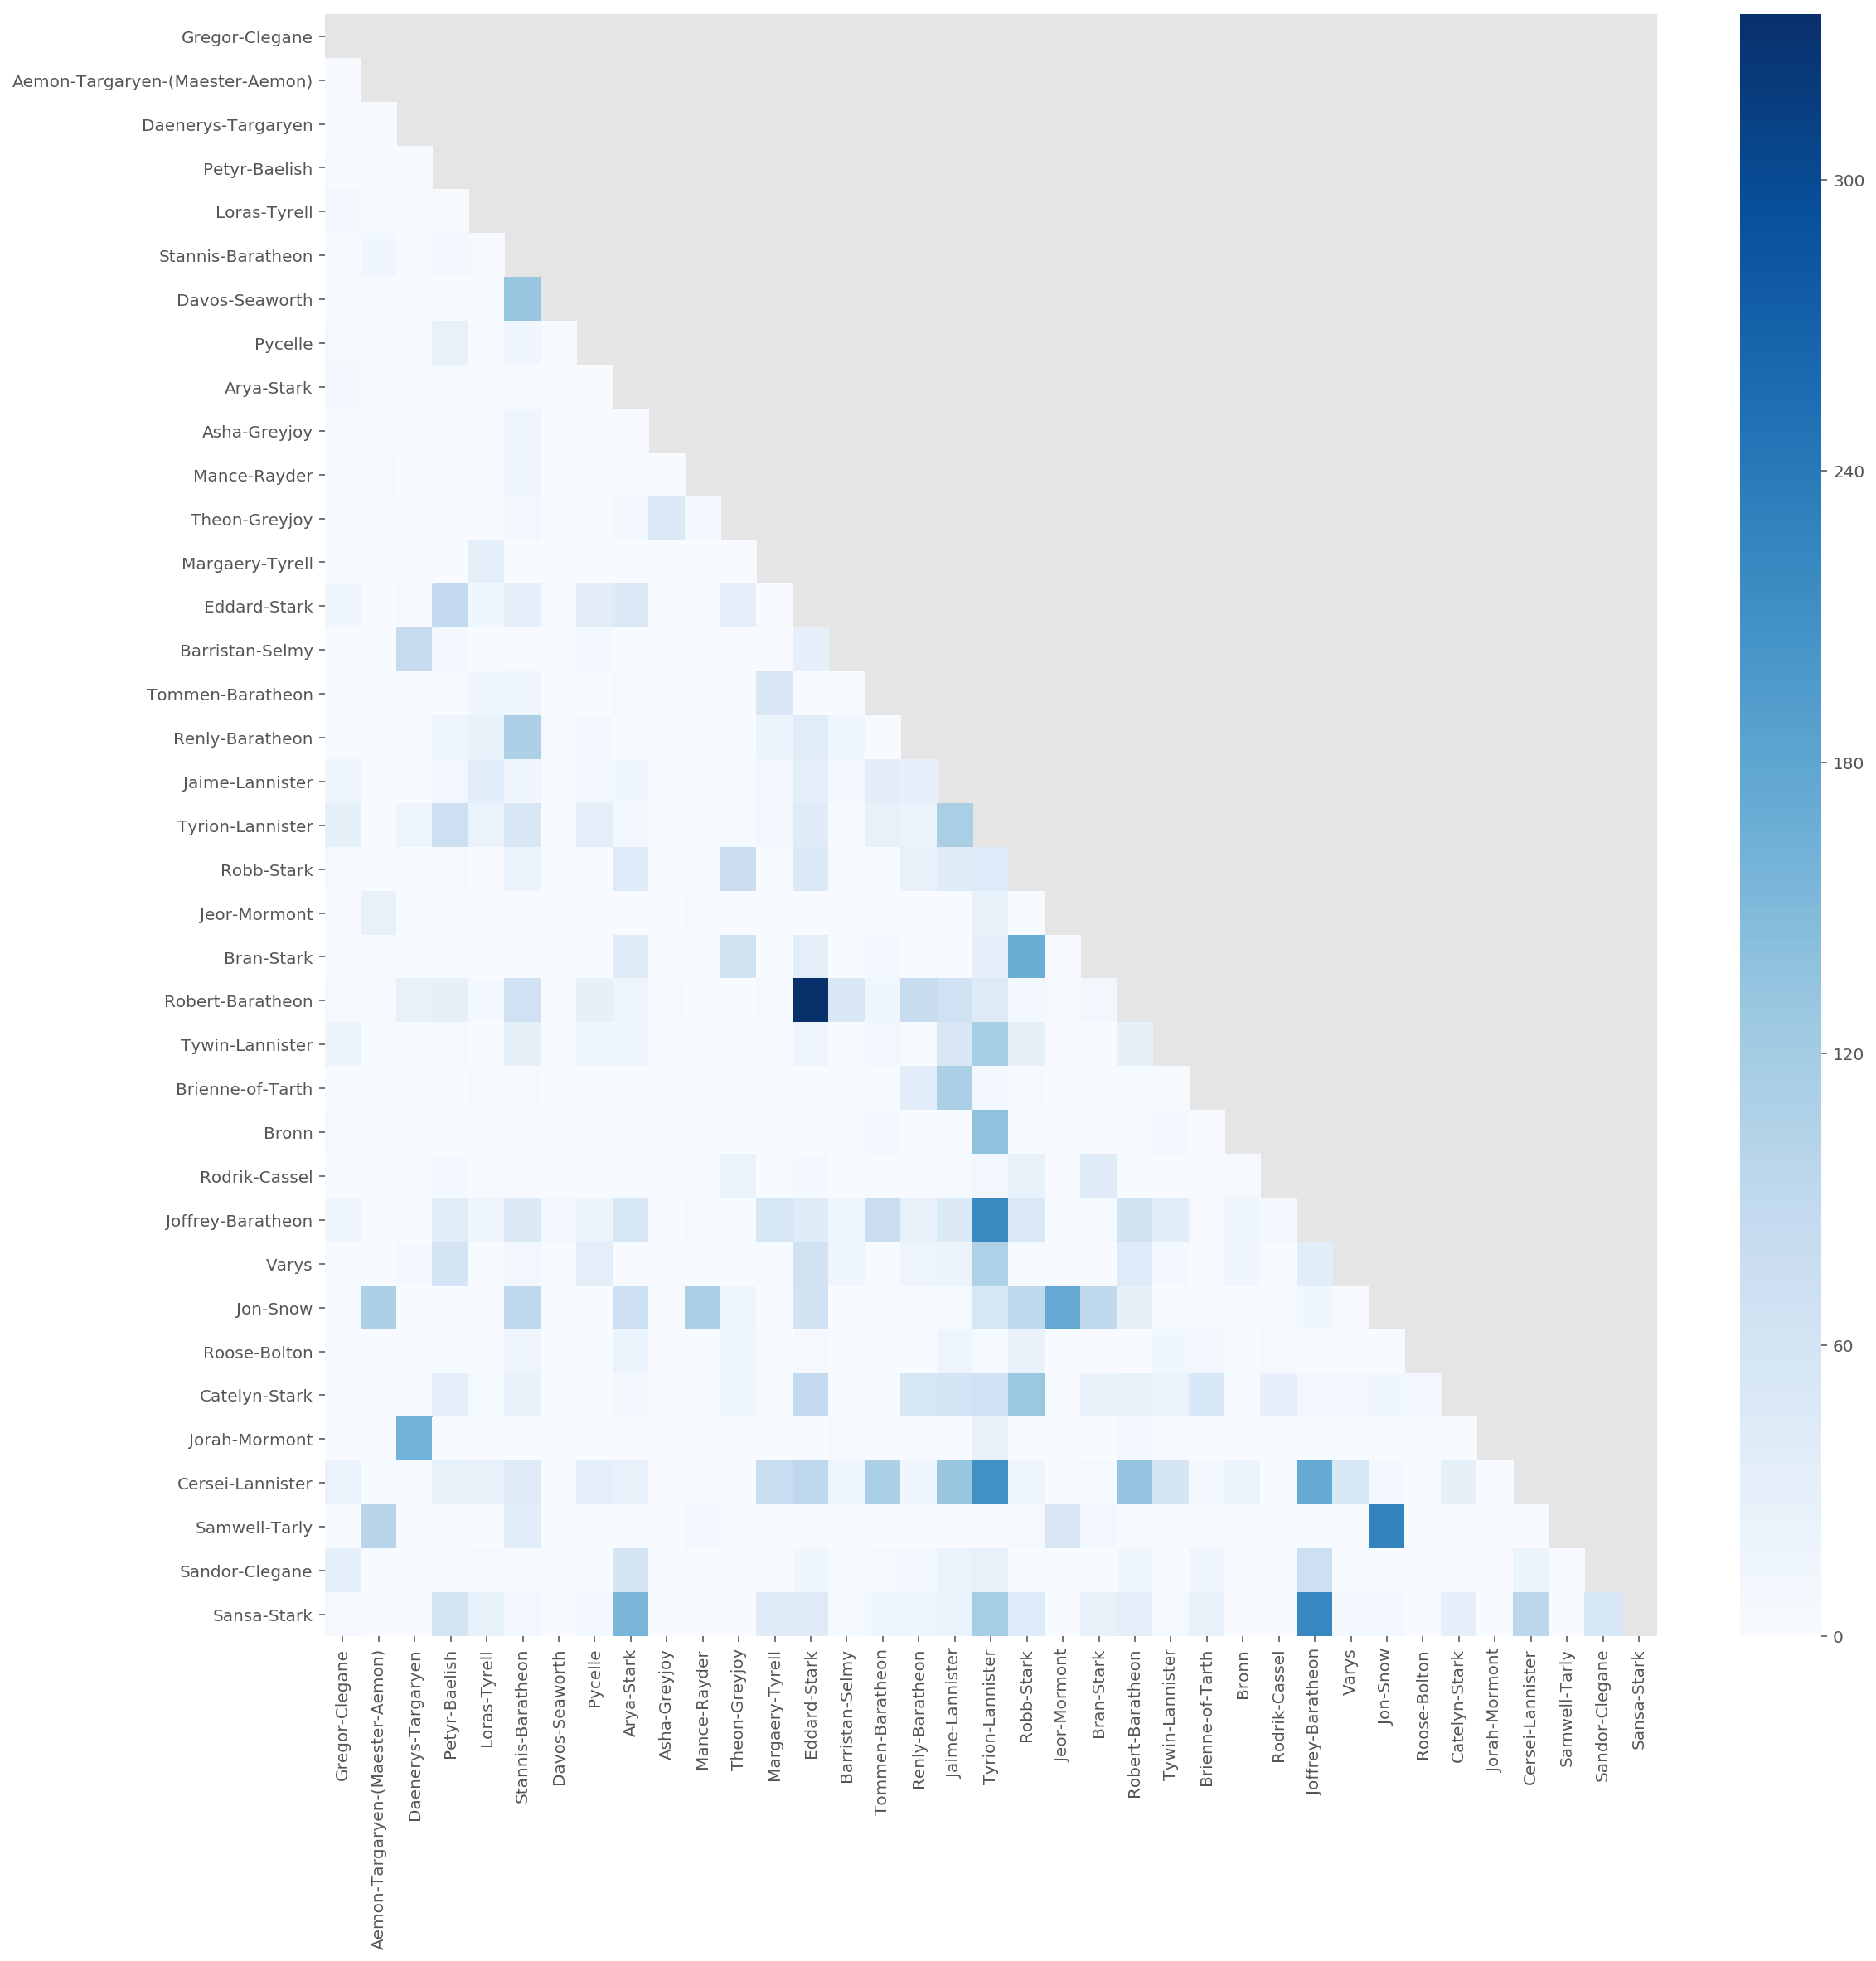

In [62]:
weight_map(weight_matrix(got_edges,got_nodes,25),18,18)

# `Who are the most 'visible' characters?`

Each character's interaction with another character has a weight and as we have explored above the more frequent those interactions occur, the weight of that connection increases. 

If we sum the total weights associated with each character we can get to a position where can understand a characters total weight in the narrative. It is a number that reflects the sum of every individual interaction a character has. In some ways a measure of presence/visibility across the network.

Let's take the edge weights from the edge dataframe and merge them on character in our node dataframe

In [63]:
#there are two weights; weight by source and weight by target
source_g = pd.DataFrame(edge.
                        groupby('Source').weight.sum())
target_g = pd.DataFrame(edge.groupby('Target').weight.sum())

In [64]:
source_g.reset_index(inplace=True)
source_g.columns=['Character','Source_Weight']
target_g.reset_index(inplace=True)
target_g.columns=['Character','Target_Weight']

In [65]:
#merging source weight / target weight and creating an aggregate of 'Total Weight'
weights = pd.merge(source_g,target_g,on='Character',how='right').fillna(0)
weights['Total_Weight'] = weights['Source_Weight'] + weights['Target_Weight'] 

In [66]:
#merging total weight on our node dataframe
got_nodes = pd.merge(got_nodes,weights,on='Character',how='left')

In [67]:
got_nodes.drop(['Source_Weight','Target_Weight'],axis=1,inplace=True)

In [68]:
got_nodes.sort_values(by='Degree',ascending=False).head()

Id          Character  Degree  Centrality      House  Total_Weight
726  726   Tyrion-Lannister     122    0.162116  Lannister        2873.0
360  360           Jon-Snow     113    0.191410   Jon-Snow        2753.0
336  336    Jaime-Lannister     101    0.100743  Lannister        1569.0
115  115   Cersei-Lannister      97    0.088598  Lannister        2232.0
667  667  Stannis-Baratheon      89    0.110159  Baratheon        1375.0

In [69]:
got_weight = got_nodes.dropna()

Unsurprisingly, total weight is correlated very positively with Degree i.e. the more unique connections a character has in the network (Degree), the higher the total weight tends to be,

In [70]:
#exploring correlation
got_weight.corr()

Id    Degree  Centrality  Total_Weight
Id            1.000000 -0.081452   -0.065821     -0.084986
Degree       -0.081452  1.000000    0.917116      0.965152
Centrality   -0.065821  0.917116    1.000000      0.910461
Total_Weight -0.084986  0.965152    0.910461      1.000000

In [71]:
#function that let's us return a subset of a dataframe on whatever variable and value we want
def frame_filter(df,metric,x):
    return df[df[metric] >= x]

Below is a plot of all characters with a degree of 200 or higher and then their total weights shown. Tyrion, Cersei and Jon-Snow top the chart.

<img src="Assets/trio.png" style="width: 400px;">

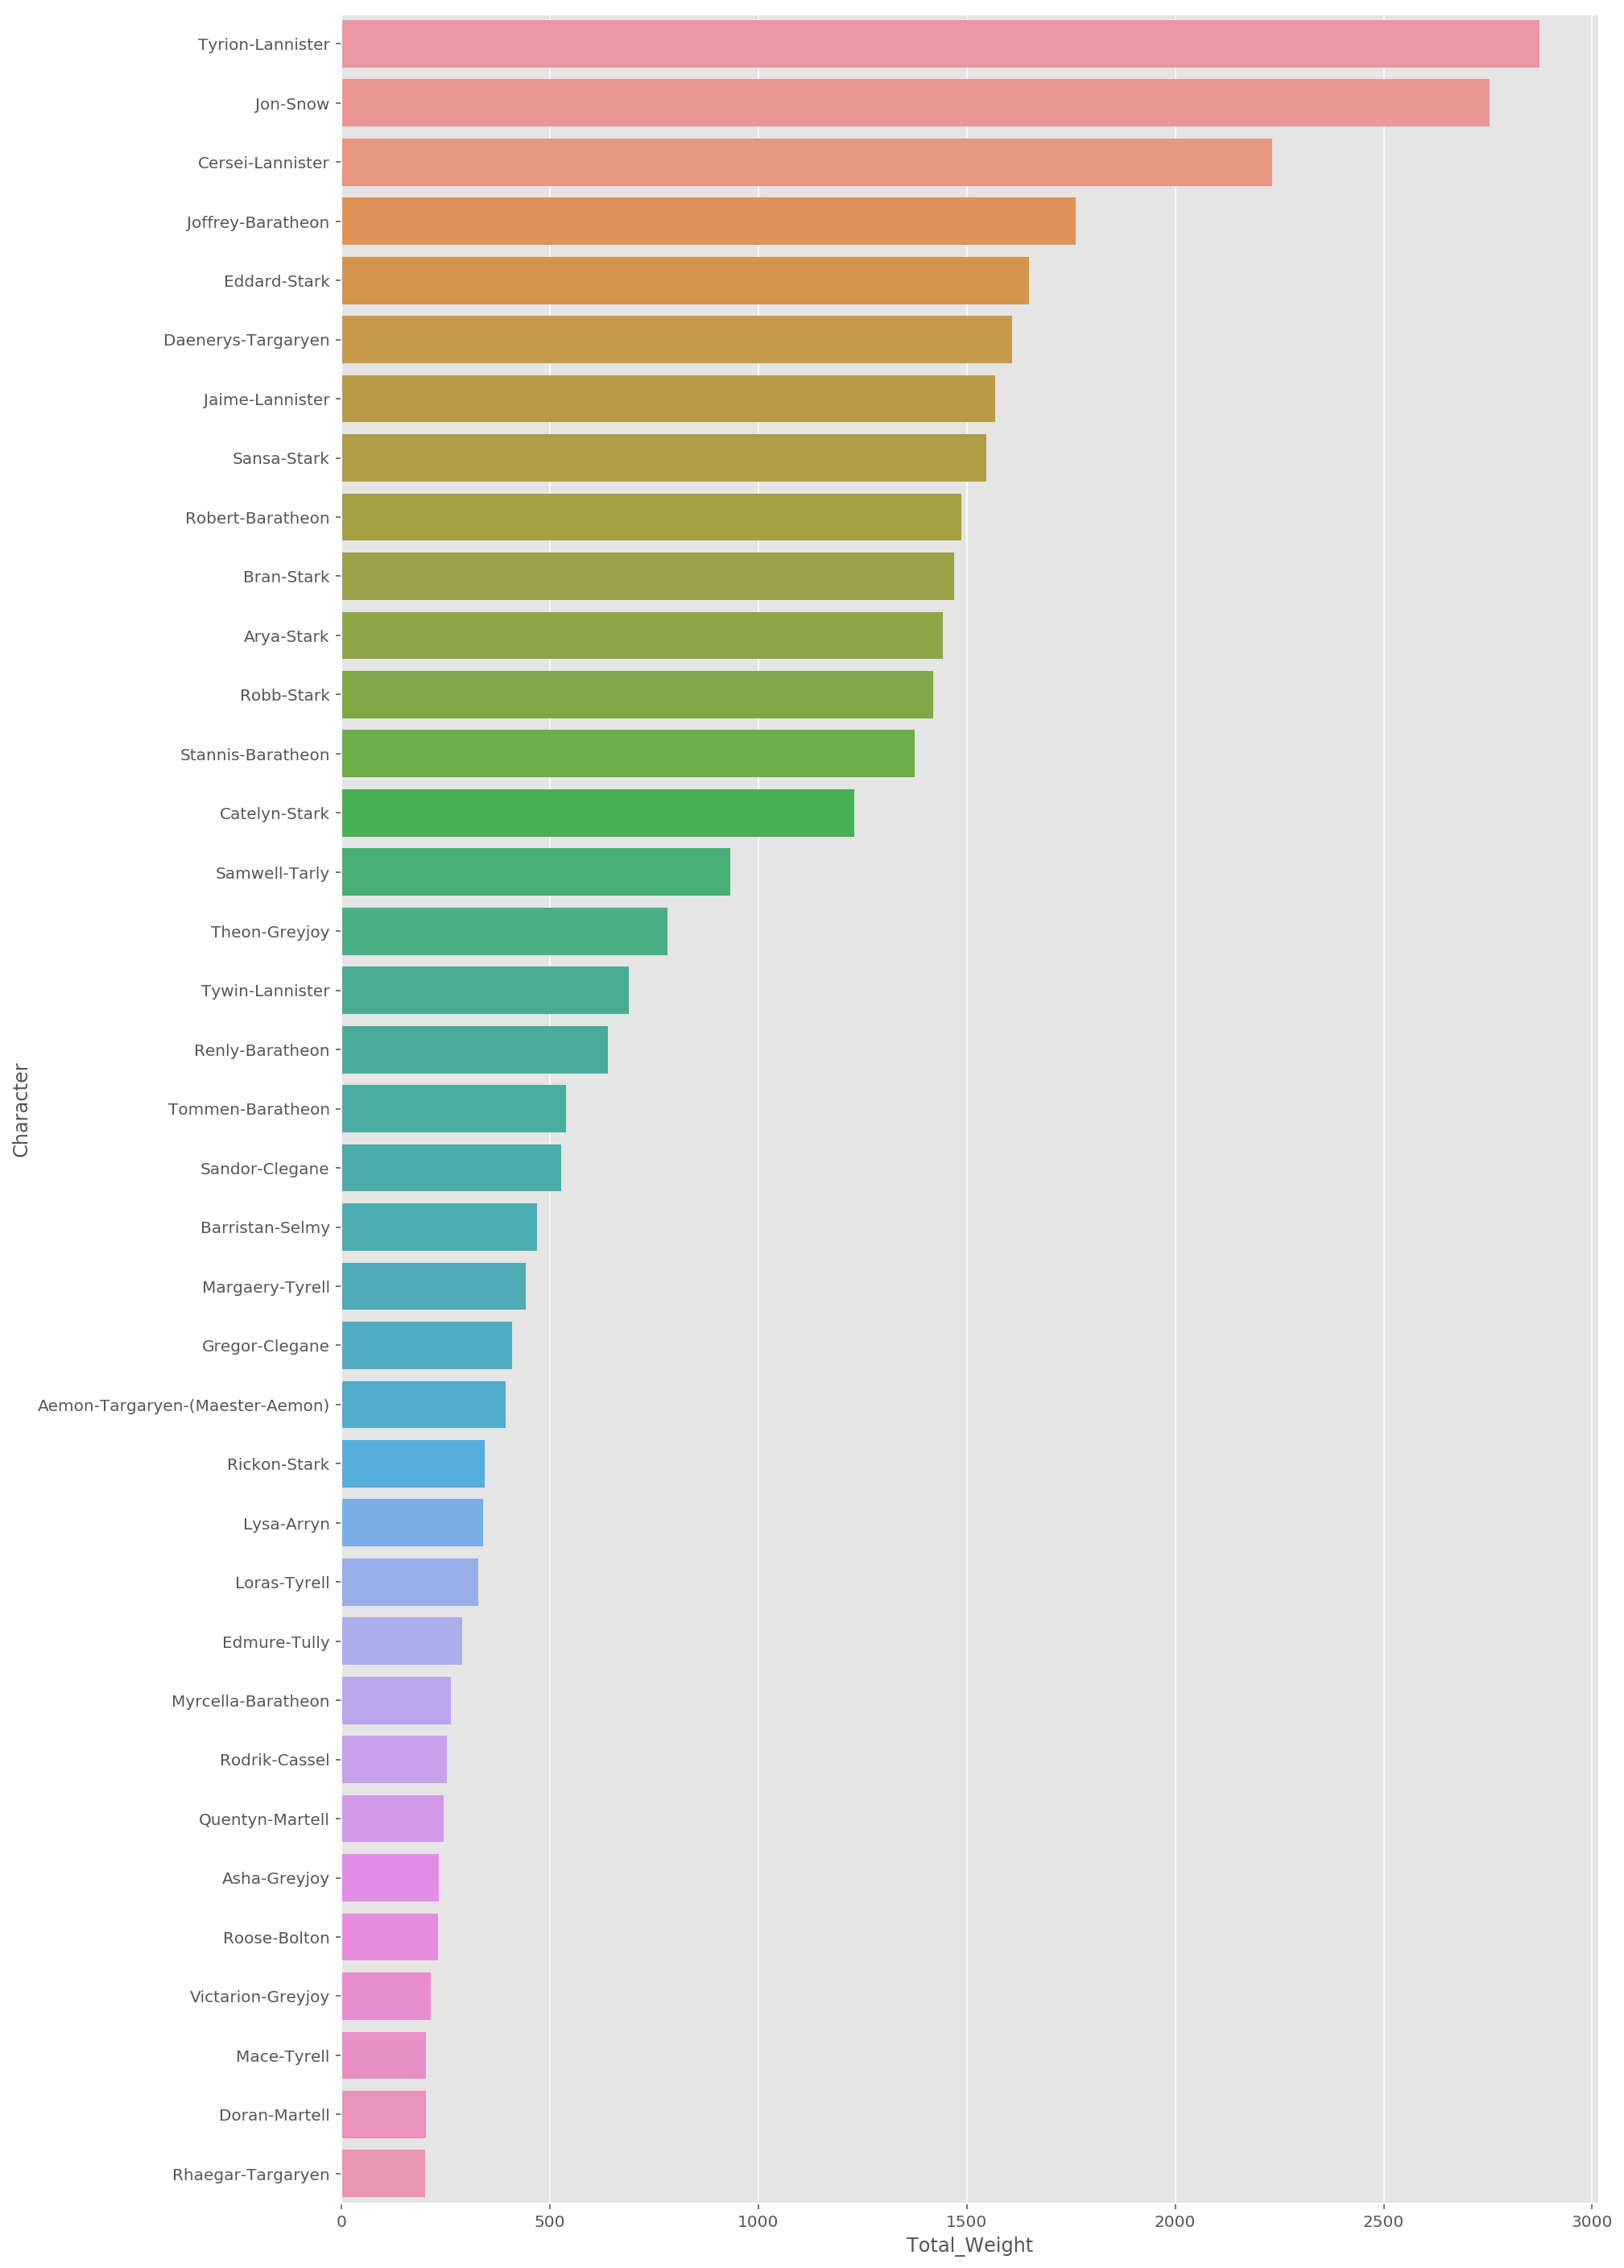

In [72]:
weight_frame = frame_filter(got_weight,'Total_Weight',200).sort_values(by='Total_Weight',ascending=False)
plt.figure(figsize = (14,25))
ax = sns.barplot(weight_frame.Total_Weight,weight_frame.Character)

<a id="devoted"></a>
## `Who are the most 'devoted' characters?`

As we've seen, the **total weight** for each character represents the total volume of interactions a character has made with all other characters across the network and is generally correlated with the degree of the character. 

If we explore the ratio between the total weight a character has and *how many* character interactions thay have made (i.e a character's degree) we can explore another dimension of each character. For example, if a character has lots of interactions with *few* characters this could be an indicator of someone very 'committed'. On the other hand, those characters that have few interactions with *lots* of characters could be described as having lots of acquaintances.

In [73]:
got_nodes['Degree_Depth'] = got_nodes['Total_Weight'] / got_nodes['Degree']

<img src="Assets/bran.jpg" style="width: 500px;">

Bran Stark tops the list of characters when it comes to the degree depth. His high degree depth tell us that he commits more of his interactions (total weight) to fewer characters (degree).

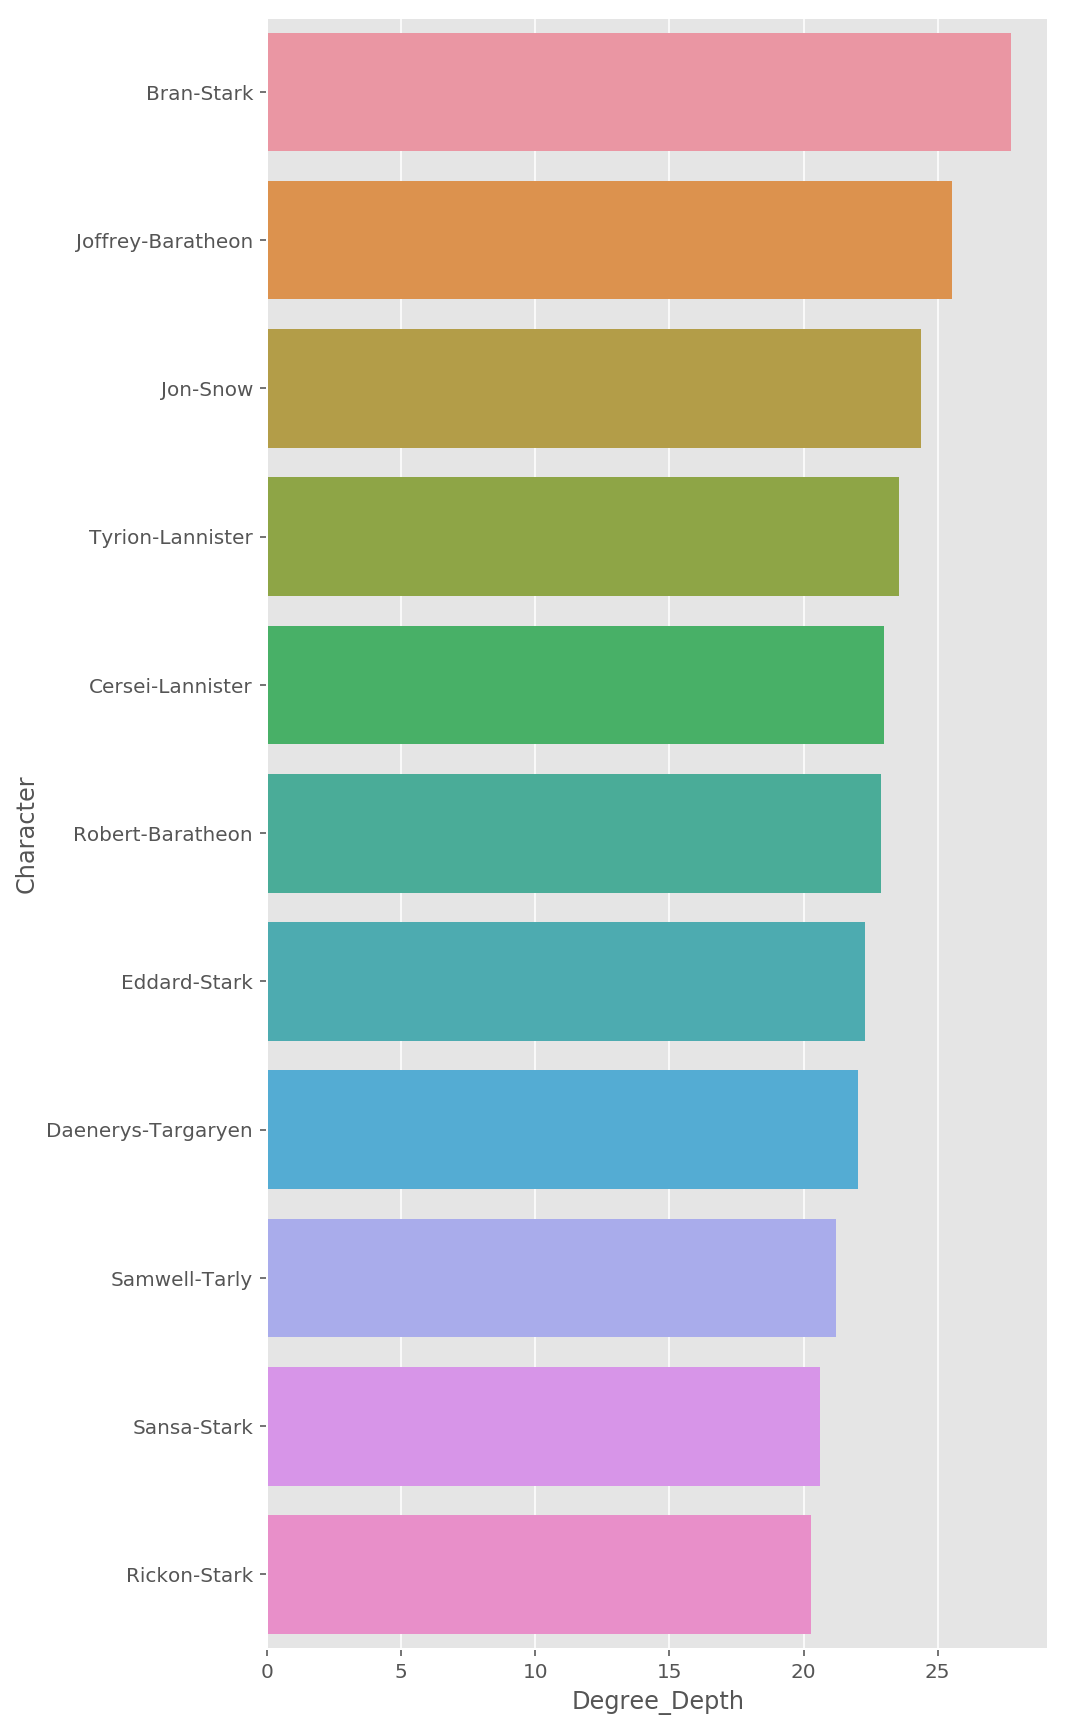

In [74]:
weight_frame = frame_filter(got_nodes.dropna(),'Degree_Depth',20).sort_values(by='Degree_Depth',ascending=False)
plt.figure(figsize = (7,15))
ax = sns.barplot(weight_frame.Degree_Depth,weight_frame.Character)

<a id="unconnected"></a>
## `Which significant characters are yet to meet?`

We can use the network to work out all the significant characters that haven't actually met yet. After all, the sum of nodes far exceeds the highest degree in this network which means that there are many characters that haven't got a narrative connection yet

*(`Note`, if you've been following the TV adaptation of GoT then there was a pivotal scene in season 7 where many key characters finally met after years of seperate storylines . However in the books, many of these characters haven't met yet, so you have to bear that in mind when you see the output from the analysis below)*

<img src="Assets/season7.jpg" style="width: 500px;">

Let's build a function that takes in an edge and node dataframe and a degree of choice, and then returns a dataframe of edges that *don't* exist in the existing network

### `Helper Functions`

In [75]:
#function that takes in a node dataframe and returns all possible edge combinations that could exist
def possible_connections(node):
    possible_connections = []
    for i in [i for i in list((node.Character))]:
        for x in [i for i in list((node.Character))]:
            possible_connections.append((i,x))
    for i,x in possible_connections:
        if i == x:
            possible_connections.remove((i,x))
    return list(set(tuple(sorted(l)) for l in possible_connections))

#function that takes in an edge dataframe and returns a list of all possible edges
def actual_connections(edge):
    merged = list(zip(list(edge.Source),list(edge.Target)))+list(zip(list(edge.Target),list(edge.Source)))
    return list(set(tuple(sorted(l)) for l in merged))  

In [76]:
def unconnected(edge,node,degree):

    edge_f = edge_filter(edge,degree)
    node_f = node_filter(edge_f,node)

    labels = [i for i in range(len(node_f.Character))]
    character_dict = dict(zip(node_f.Character,labels))
    edge_f['Source_Code'] = edge_f['Source'].apply(lambda x: character_dict[x])
    edge_f['Target_Code'] = edge_f['Target'].apply(lambda x: character_dict[x])

    missing_connections = []

    for i in possible_connections(node_f):
        if i in actual_connections(edge_f):
            pass
        else:
            missing_connections.append(i)

    return pd.DataFrame(missing_connections,columns=['Source','Target']).sort_values(by='Source',ascending=True).reset_index(drop=True)

When we look at the counts of how many 'significant' characters each character hasn't met  - we see that Daenerys tops the chart. This makes sense; most of her storylines have been set in far off parts of Westeros away from most other characters.

In [77]:
pd.DataFrame(
    list(unconnected(got_edges,got_nodes,50).Source)+list(unconnected(got_edges,got_nodes,50).Target),
    columns=['Character']).Character.value_counts()

Daenerys-Targaryen    10
Theon-Greyjoy          5
Stannis-Baratheon      3
Bran-Stark             3
Sansa-Stark            2
Joffrey-Baratheon      2
Jaime-Lannister        2
Arya-Stark             2
Robert-Baratheon       1
Catelyn-Stark          1
Robb-Stark             1
Jon-Snow               1
Cersei-Lannister       1
Name: Character, dtype: int64

Let's find a way to present this in a more interesting way. The function below takes an edge and node dataframe alongside a degree and returns a data frame with every possible edge that could exist and a 'weight' variable denoting '1' if the edge exits in the original edge dataframe and '0' if it doesn't exist. 

In [78]:
#function thst takes an edge and node dataframe along with a degre of 
def unconnected_weight(edge,node,degree):
    
    edge_f = edge_filter(edge,degree)
    node_f = node_filter(edge_f,node)

    labels = [i for i in range(len(node_f.Character))]
    character_dict = dict(zip(node_f.Character,labels))
    edge_f['Source_Code'] = edge_f['Source'].apply(lambda x: character_dict[x])
    edge_f['Target_Code'] = edge_f['Target'].apply(lambda x: character_dict[x])

    binary_connections = []

    for i in possible_connections(node_f):
        if i in actual_connections(edge_f):
            z = (i,1)
            binary_connections.append(z)
        else:
            z = (i,0)
            binary_connections.append(z)
    
    source = [i[0][0] for i in binary_connections]
    target = [i[0][1] for i in binary_connections]
    weight = [i[1] for i in binary_connections]
    
    return pd.DataFrame({'Source':source,'Target':target,'weight':weight})

In [79]:
def binary_matrix(edge,node,degree):
    new_node = pd.DataFrame(list(set(list(unconnected_weight(edge,node,degree).Source)
                             +list(unconnected_weight(edge,node,degree).Target))),columns=['Id'])
    labels = [i for i in range(len(new_node.Id))]
    new_node['Id_Code'] = new_node.index

    temp_dict = dict(zip(new_node.Id,labels))

    new_edge = unconnected_weight(edge,node,degree)

    new_edge['Source_Code'] = new_edge['Source'].apply(lambda x: temp_dict[x])
    new_edge['Target_Code'] = new_edge['Target'].apply(lambda x: temp_dict[x])
    
    G=nx.Graph()
    G.add_nodes_from(new_node.Id_Code)
    for i in tuple_extractor_edge_weight(new_edge):
        G.add_edge(i[0],i[1],weight=i[2])

    a = pd.DataFrame(nx.adjacency_matrix(G,weight='weight').todense())
    a.columns = list(temp_dict.keys())
    a.index = list(temp_dict.keys())
    
    mask = np.zeros_like(a)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize = (10,10))
    ax = sns.heatmap(a,mask=mask,square=False,cbar=False)
    return ax

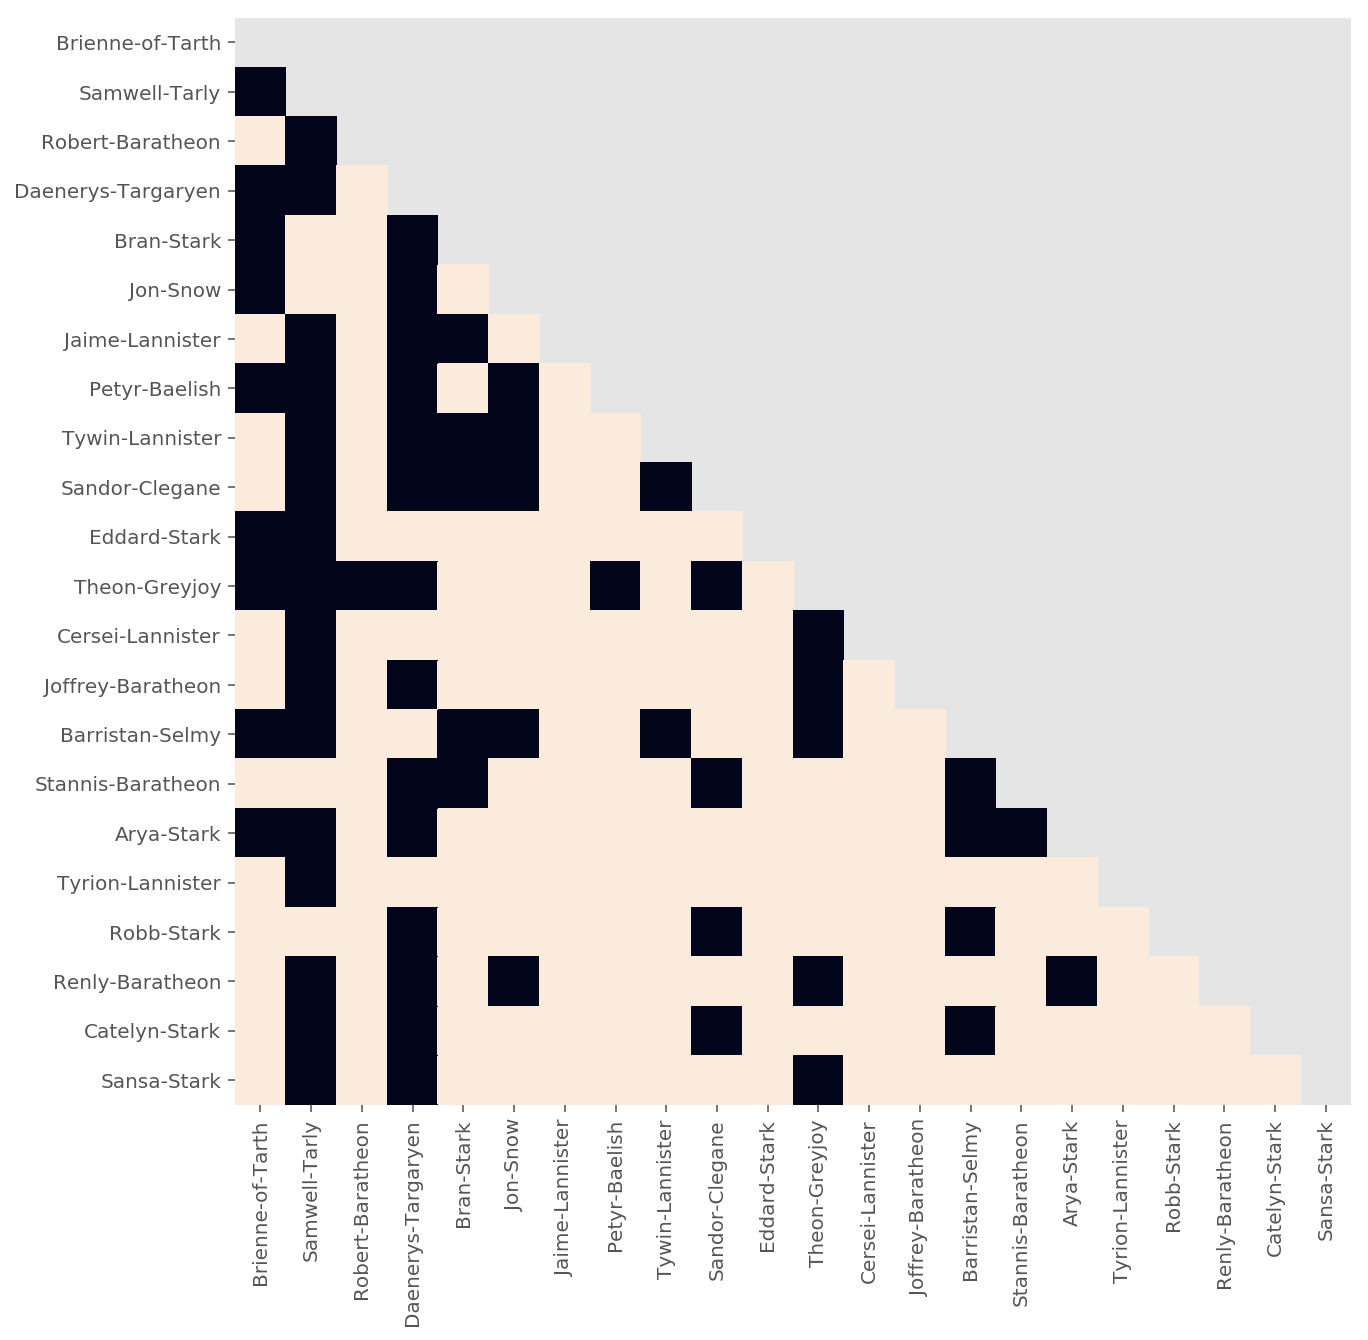

In [80]:
binary_matrix(got_edges,got_nodes,35)

<a id="summary"></a>
# `Summary`

Using network science techniques can be a very useful way to quantify how characters are connected in a story. It can tell us where narrative connections occur most frequently and which characters are most important in linking up storylines.

# `How to progress this analysis`

## `Good vs. Evil`

What would be useful is to add extra dimensions that describe the nature/sentiment of some relationships. The weight of the Jon-Snow/Samwell-Tarly relationship (228) is roughly the same as Jorrey-Baratheon/Sansa-Stark relationship (222) but they're fundamentally different in sentiment. 

A key dimension of most stories is the interplay between antagonist and protagonist; the clash of good and evil. Currently my analysis doesn't have a way to explore that. This is something that would be really interesting to explore in a future iteration of this study.

## Different story types

It would be interesting to run this kind of analysis on other kinds of stories 



methodoogy